## 1. 데이터 불러오기

* PSG = *PSG.edf
* Hypnogram = *Hypnogram.edf

### PSG(PolySomnoGraphy)?
PSG is a multi-parameter type of sleep study and a diagnostic tool in sleep medicine. ploysomnogram is the test result, also abbreviated PSG

### Hypnogram?
A hypnogram that is a form of PSG is a graph that represents the stages of sleep as a finction of time

#### [Sleep Stages](https://www.sleepfoundation.org/stages-of-sleep)

In [1]:
import matplotlib.pyplot as plt
from src.data.dataframe import BaseDataSet

basedataset = BaseDataSet()
eeg_df = basedataset.make_eeg_df(id := 0, column_select = [0])
stage_df = basedataset.make_stage_df(id)

In [2]:
eeg_df

,EEG Fpz-Cz
0,5.016850
1,-2.578755
2,1.359707
3,-2.391209
4,-5.204396
...,...
7949995,11.299634
7949996,3.610256
7949997,5.298168
7949998,-4.641758


In [3]:
stage_df.head()

,time,duration,sleep_stage
0,0.0,30630.0,Sleep stage W
1,30630.0,120.0,Sleep stage 1
2,30750.0,390.0,Sleep stage 2
3,31140.0,30.0,Sleep stage 3
4,31170.0,30.0,Sleep stage 2


## 2. 데이터 시각화

### 2-1 PSG

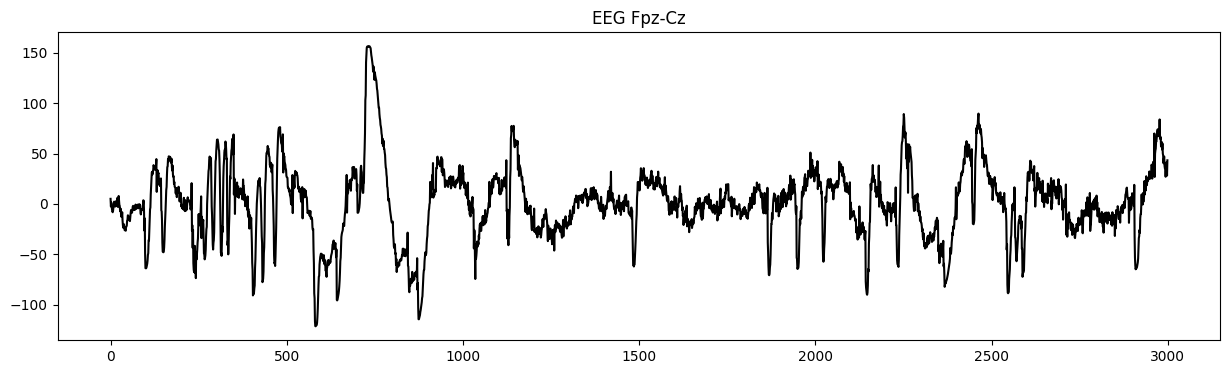

In [4]:
time = 3000  # sample rate = 100Hz
columns = eeg_df.columns
plt.figure(figsize=(15, 4*len(columns)))
for i in range(len(columns)):
    plt.subplot(len(columns), 1, i+1)
    plt.plot(range(len(eeg_df[columns[i]][:time])), eeg_df[columns[i]][:time], color='black')
    plt.title(columns[i])
plt.show()

### 2-2 Band-pass filter

* EEG Fpz-Cz

In [5]:
from src.data.dataframe import FeatureEngineering
dataset = FeatureEngineering()
filtered_df = dataset.make_filtered_df(id, column_select=[0])
filtered_df.head()

,EEG Fpz-Cz_Delta,EEG Fpz-Cz_Theta,EEG Fpz-Cz_Alpha,EEG Fpz-Cz_Beta,EEG Fpz-Cz_Gamma
0,0.005416,0.007861,0.007861,0.385023,0.248500
1,0.027213,0.036470,0.031208,0.234146,-0.948507
2,0.066557,0.077015,0.045974,-1.271051,1.223817
3,0.111552,0.098429,0.012342,-0.987337,-0.184091
4,0.142709,0.066239,-0.080861,0.860521,-1.588314


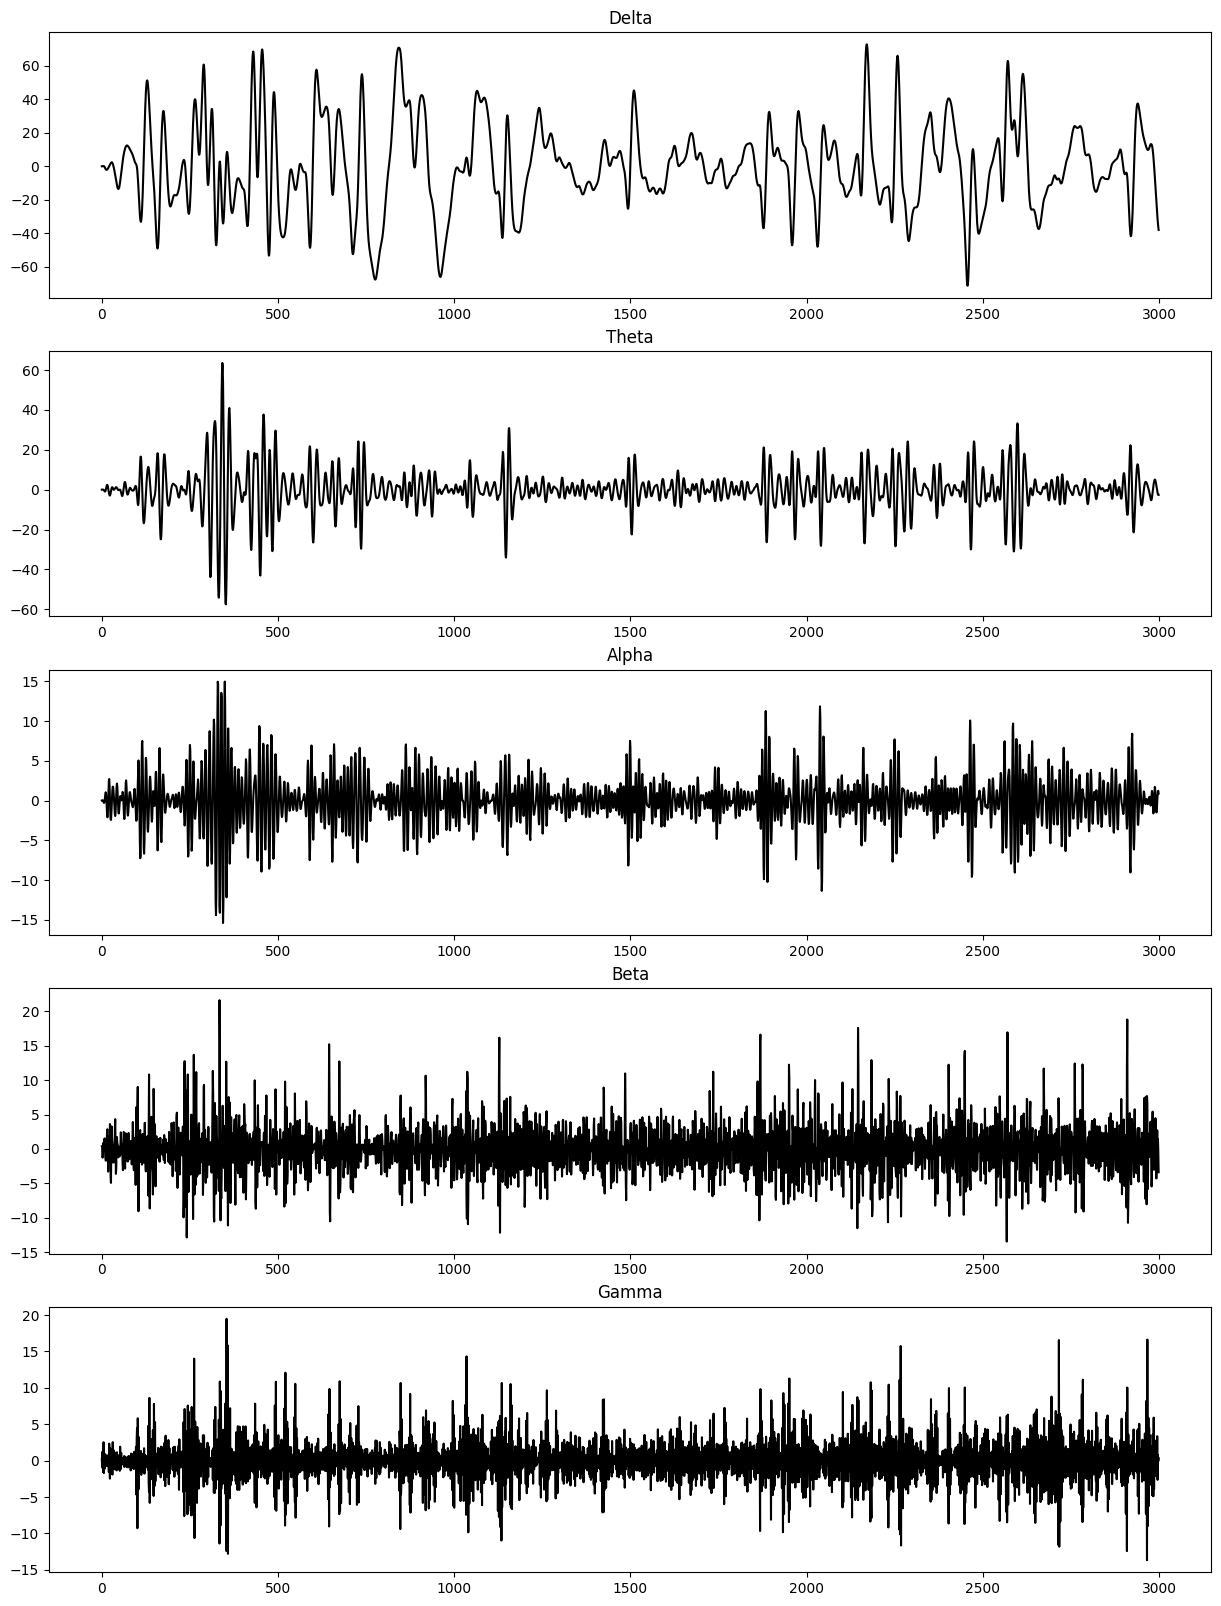

In [6]:
BANDS = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
columns = filtered_df.columns
time = 3000
plt.figure(figsize=(15, 4*len(columns)))
for i in range(rows:=len(columns)):
    plt.subplot(rows, 1, i+1)
    plt.plot(range(len(filtered_df[columns[i]][:time])), filtered_df[columns[i]][:time], color="black")
    plt.title(BANDS[i])
plt.show()

### 2-3 Fourier Transform 

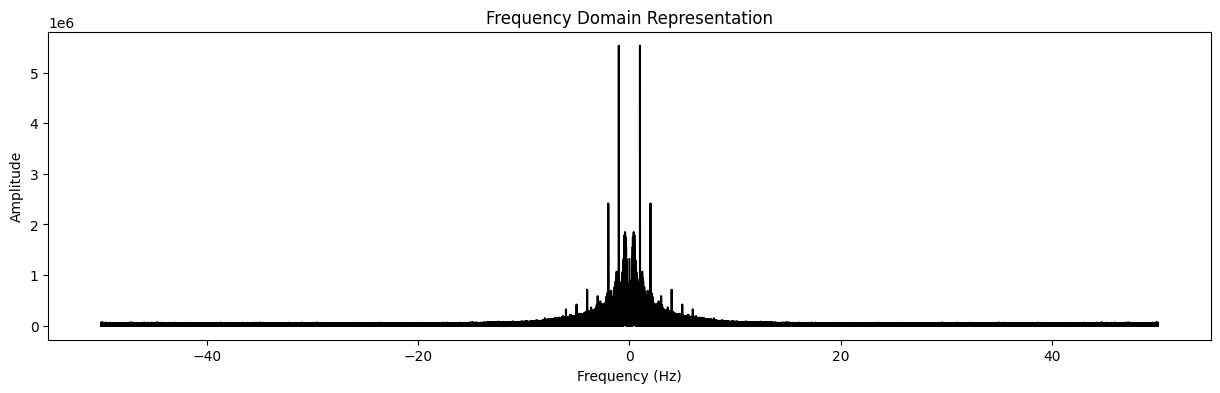

In [7]:
from scipy.fft import fft, fftfreq
import numpy as np

sfreq = 100.0  # sample rate
n = len(eeg_df['EEG Fpz-Cz'].values)
yf = fft(eeg_df['EEG Fpz-Cz'].values)
xf = fftfreq(n, 1 / sfreq)

plt.figure(figsize=(15, 4))
plt.plot(xf, np.abs(yf), color='black')
plt.title('Frequency Domain Representation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [8]:
dataset.make_fourier_transformed_df(id, column_select=[0]).head()

,EEG Fpz-Cz_fourier_transed_mean,EEG Fpz-Cz_fourier_transed_median,EEG Fpz-Cz_fourier_transed_min,EEG Fpz-Cz_fourier_transed_max,EEG Fpz-Cz_fourier_transed_std,EEG Fpz-Cz_fourier_transed_skew,EEG Fpz-Cz_fourier_transed_kurtosis
0,754.152166,297.644373,2.921759,31439.605060,1843.629128,8.347972,100.422926
1,768.871580,483.552644,5.544126,21577.490571,1223.737676,7.317175,85.543564
2,712.033570,399.782182,11.506828,27020.022845,1585.465380,8.998934,106.149046
3,480.930390,253.047824,5.578621,9629.377359,858.058143,5.271987,34.178983
4,474.090956,229.139217,4.122734,11373.883468,801.356417,4.996928,38.328554


## 3. 데이터 생성

In [9]:
from src.data.dataframe import make_train_df

train_df = make_train_df(
    id_select=list(range(2)),
    column_select=[0],
    pre_next_rate=0
)
train_df.head()

In [ ]:
from src.model.train import train_valid_test_split

X_train, X_valid, X_test, y_train, y_valid, y_test, TARS = train_valid_test_split(
    train_df=train_df,
    test_size=0.2,
    valid_size=0.5,
    random_state=42,
    oversampling=True  # class imbalance를 oversampling로 해결
)
y_train.value_counts()

## 4. Hydra: Parameter 관리

In [ ]:
import hydra
from hydra.core.global_hydra import GlobalHydra

def initialize_hydra(config_name: str = "config", config_path: str = "conf/Bpass_Ftrans/"):
    try:
        hydra.initialize(config_path=config_path, version_base=None)
    except ValueError:
        GlobalHydra.instance().clear()
        hydra.initialize(config_path=config_path, version_base=None)

initialize_hydra()

cfg = hydra.compose(config_name="P1")
print(cfg)
print(type(cfg))

## 5. 학습

In [ ]:
from src.model.model import Model
model = Model()
model.train_test(cfg)

## 6. 모델 성능 평가

In [ ]:
print(f'''
Test______________________
Accuracy: {model.test_accuracy*100:.3f} %
Weighted F1-score: {model.test_f1_weight*100:.3f} %
Macro F1-score: {model.test_f1_macro*100:.3f} %

Unknown___________________
Accuracy: {model.unknown_accuracy*100:.3f} %
Weighted F1-score: {model.unknown_f1_weight*100:.3f} %
Macro F1-score: {model.unknown_f1_macro*100:.3f} %

Model_____________________
{model.model}
''')
